# Extracting EEG data from the TUH Abnormal EEG Corpus

Extract all EEG data from the dataset, analyse and apply filters. Split into epochs/windows. Export for training.


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

import math

import mne
from mne.filter import notch_filter

import csv

## Load Data From Dataset


In [14]:
# Set data location
DEV_DATA_FOLDER = "E:/edf/dev"
SEIZURE_TYPE = "focal"  # "absence", "tonic-clonic", "???"

# Set absence data file names from absence_files.txt
SEIZURE_FILE_NAMES = []
with open(f"processed_data/{SEIZURE_TYPE}/{SEIZURE_TYPE}_files.txt", "r") as f:
    for i in f.readlines():
        SEIZURE_FILE_NAMES.append(DEV_DATA_FOLDER + i[:-1])


# Change index to change which absence seizure to load
def import_data(seizure_idx):
    raw = mne.io.read_raw_edf(SEIZURE_FILE_NAMES[seizure_idx])
    print(SEIZURE_FILE_NAMES[seizure_idx])
    print(raw.load_data())
    return raw

In [102]:
seizure_idx = 5
raw = import_data(seizure_idx)

Extracting EDF parameters from E:\edf\dev\01_tcp_ar\084\00008460\s004_2012_06_21\00008460_s004_t000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
E:/edf/dev/01_tcp_ar/084/00008460/s004_2012_06_21/00008460_s004_t000.edf
Reading 0 ... 153855  =      0.000 ...   600.996 secs...
<RawEDF | 00008460_s004_t000.edf, 34 x 153856 (601.0 s), ~39.9 MB, data loaded>


## Select n Channels


In [103]:
front_channels = [
    "EEG FP1-REF",
    "EEG FP2-REF",
    "EEG F7-REF",
    "EEG F8-REF",
    "EEG FZ-REF",
    "EEG F3-REF",
    "EEG F4-REF",
]

exclude_channels = [i for i in raw.info["ch_names"] if i not in front_channels]

In [104]:
raw.drop_channels(
    exclude_channels
)  # Drop channels in excl_channels, keep only channels in channels

raw = raw.resample(250)

print(raw.info["sfreq"], print(len(raw.info["ch_names"])))

7
250.0 None


In [105]:
print(raw.info["ch_names"])

['EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG F7-REF', 'EEG F8-REF', 'EEG FZ-REF']


## Analyse and Filter Data


In [106]:
%%capture
# Plot raw data
raw.plot()

Effective window size : 8.192 (s)


C:\Users\loicl\AppData\Local\Temp\ipykernel_26368\854838781.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd().plot()
c:\Users\loicl\Documents\UniWork\Year 3\Dissertation\TinyML-for-Epileptic-Seizures\.venv\Lib\site-packages\mne\viz\utils.py:165: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


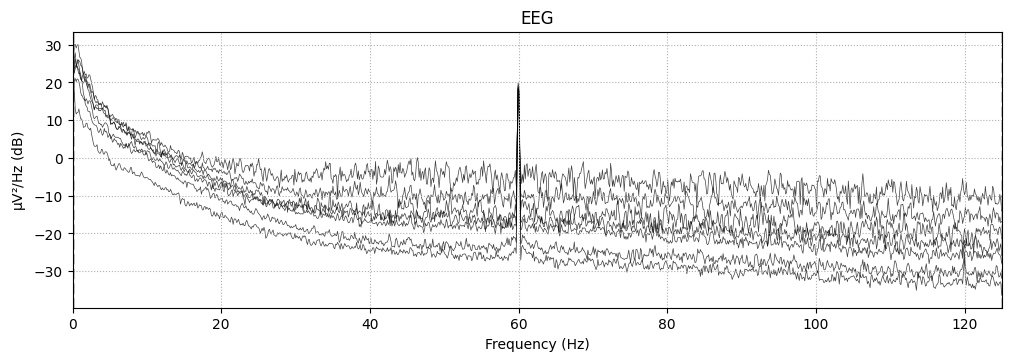

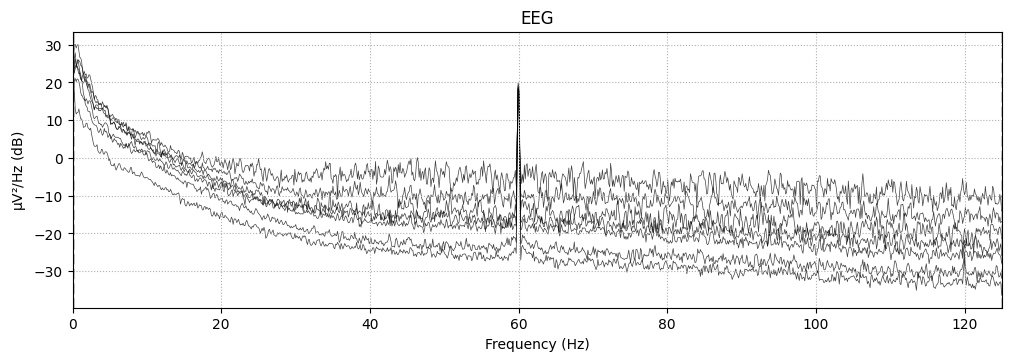

In [107]:
# Plot Power Spectral Density
raw.compute_psd().plot()

In [108]:
raw.notch_filter(60)  # 60 Hz notch filter
raw.filter(None, 35, fir_design="firwin")  # 10 Hz lowpass filter
# raw = mne.channels.combine_channels(raw, dict(new=[0, 1, 2, 3, 4]), method="mean")

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1651 samples (6.604 s)

Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 35 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 8.75 Hz (-6 dB cutoff frequency: 39.38 Hz)
- Filter length: 95 samp

Measurement date,"June 21, 2012 15:42:40 GMT"
Experimenter,Unknown
Participant,00008460
Digitized points,Not available
Good channels,7 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,35.00 Hz


# Create and Apply Annotations


## Create Labels


In [109]:
def format_annotations(annotations_file):
    annotations_list = []
    with open(annotations_file, "r") as f:
        for i, v in enumerate(f.readlines()):
            if i >= 2:
                row = v.split(" ")
                row.remove(row[-1])
                annotations_list.append(row)
    return annotations_list

In [110]:
# Import annotations from annotation file
annotations_from_file = format_annotations(
    annotations_file=f"processed_data/{SEIZURE_TYPE}/annotations/{seizure_idx+1}/annot.tse"
)

max_annot_time = annotations_from_file[-1][1]
if float(max_annot_time) < float(raw.times[-1]):
    print(float(raw.times[-1]), float(max_annot_time))
    print("Needs Cropping")
annotations_from_file

[['0.0000', '275.3065', 'bckg'],
 ['275.3065', '342.7276', 'fnsz'],
 ['342.7276', '501.2022', 'bckg'],
 ['501.2022', '579.4460', 'fnsz'],
 ['579.4460', '601.0000', 'bckg']]

Remove unnanotated data


In [111]:
if float(max_annot_time) < float(raw.times[-1]):
    print("Cropping")
    raw = raw.crop(
        tmin=0.0, tmax=float(max_annot_time)
    )  # Remove anything after last annotation, if it exists

Collect beginning time and duration of each label


In [112]:
annotation_times = [[], [], []]

for i, v in enumerate(annotations_from_file):
    if v[2] == "bckg":
        annotation_times[0].append(float(v[0]))
        annotation_times[1].append(float(v[1]) - float(v[0]))
        annotation_times[2].append("0")
    elif v[2] == "tcsz" or v[2] == "absz" or v[2] == "tnsz" or v[2] == "fnsz":
        annotation_times[0].append(float(v[0]))
        annotation_times[1].append(float(v[1]) - float(v[0]))
        annotation_times[2].append("1")
    elif v[2] == "gnsz":
        annotation_times[0].append(float(v[0]))
        annotation_times[1].append(float(v[1]) - float(v[0]))
        annotation_times[2].append("2")

Apply annotations to the data


Used Annotations descriptions: ['0', '1']


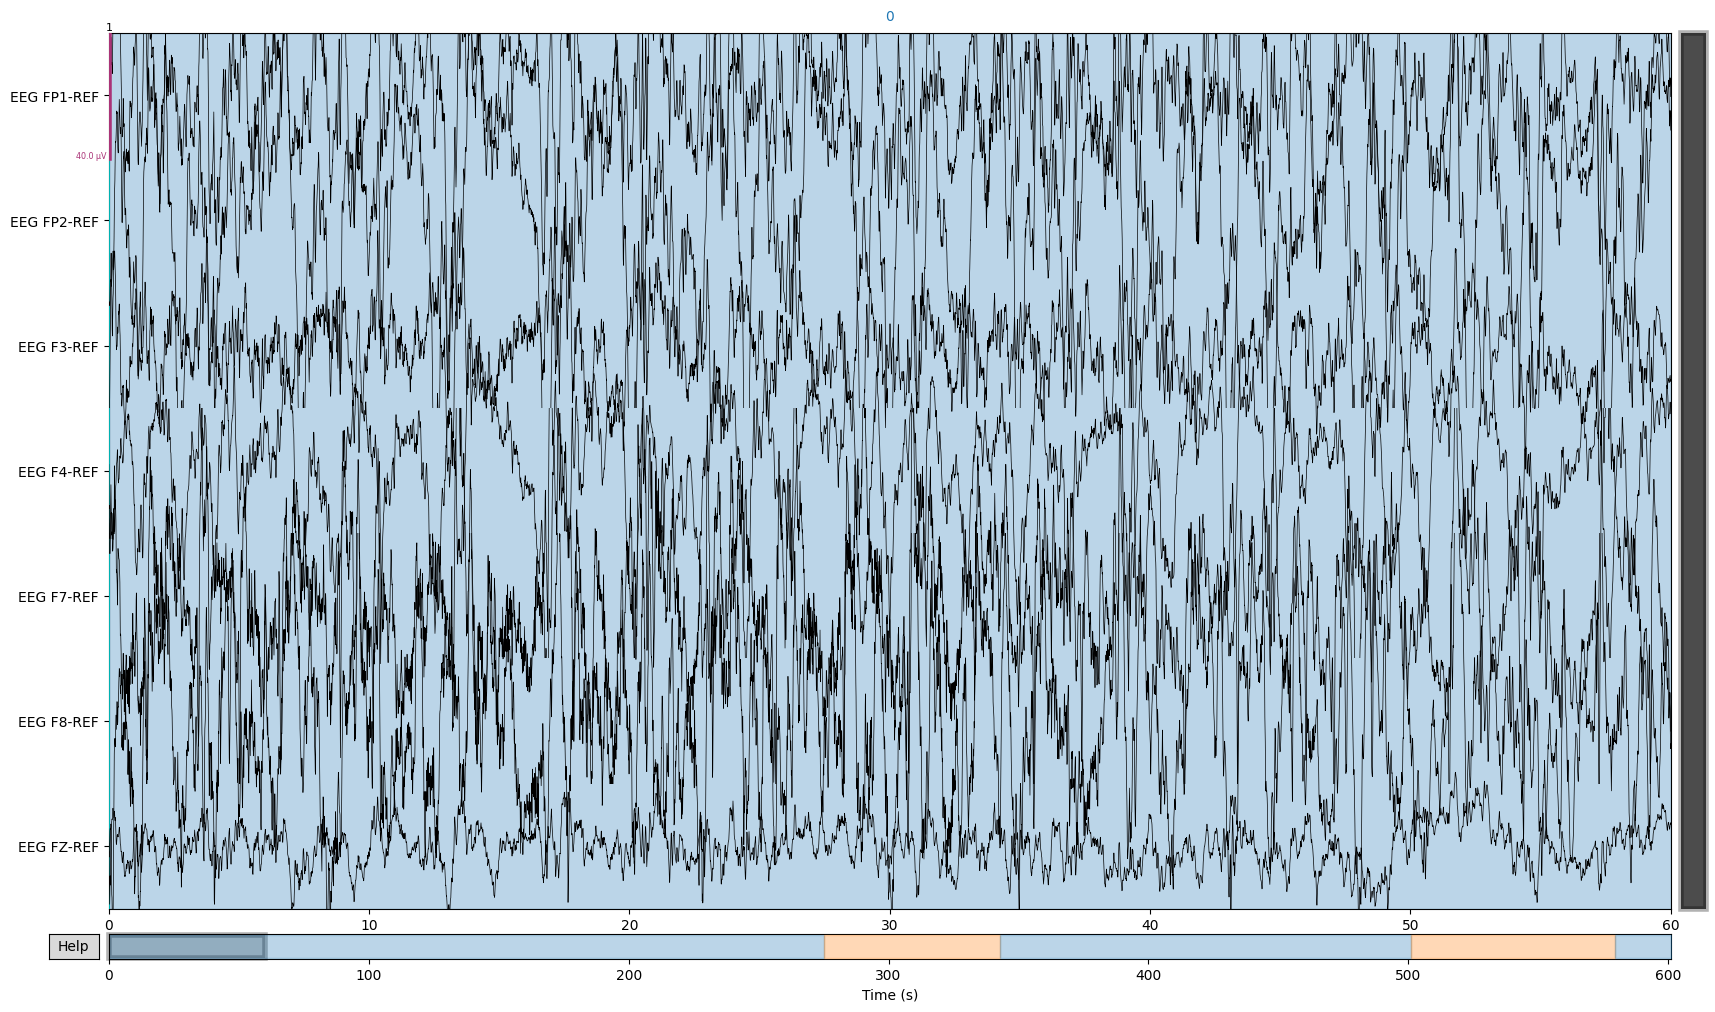

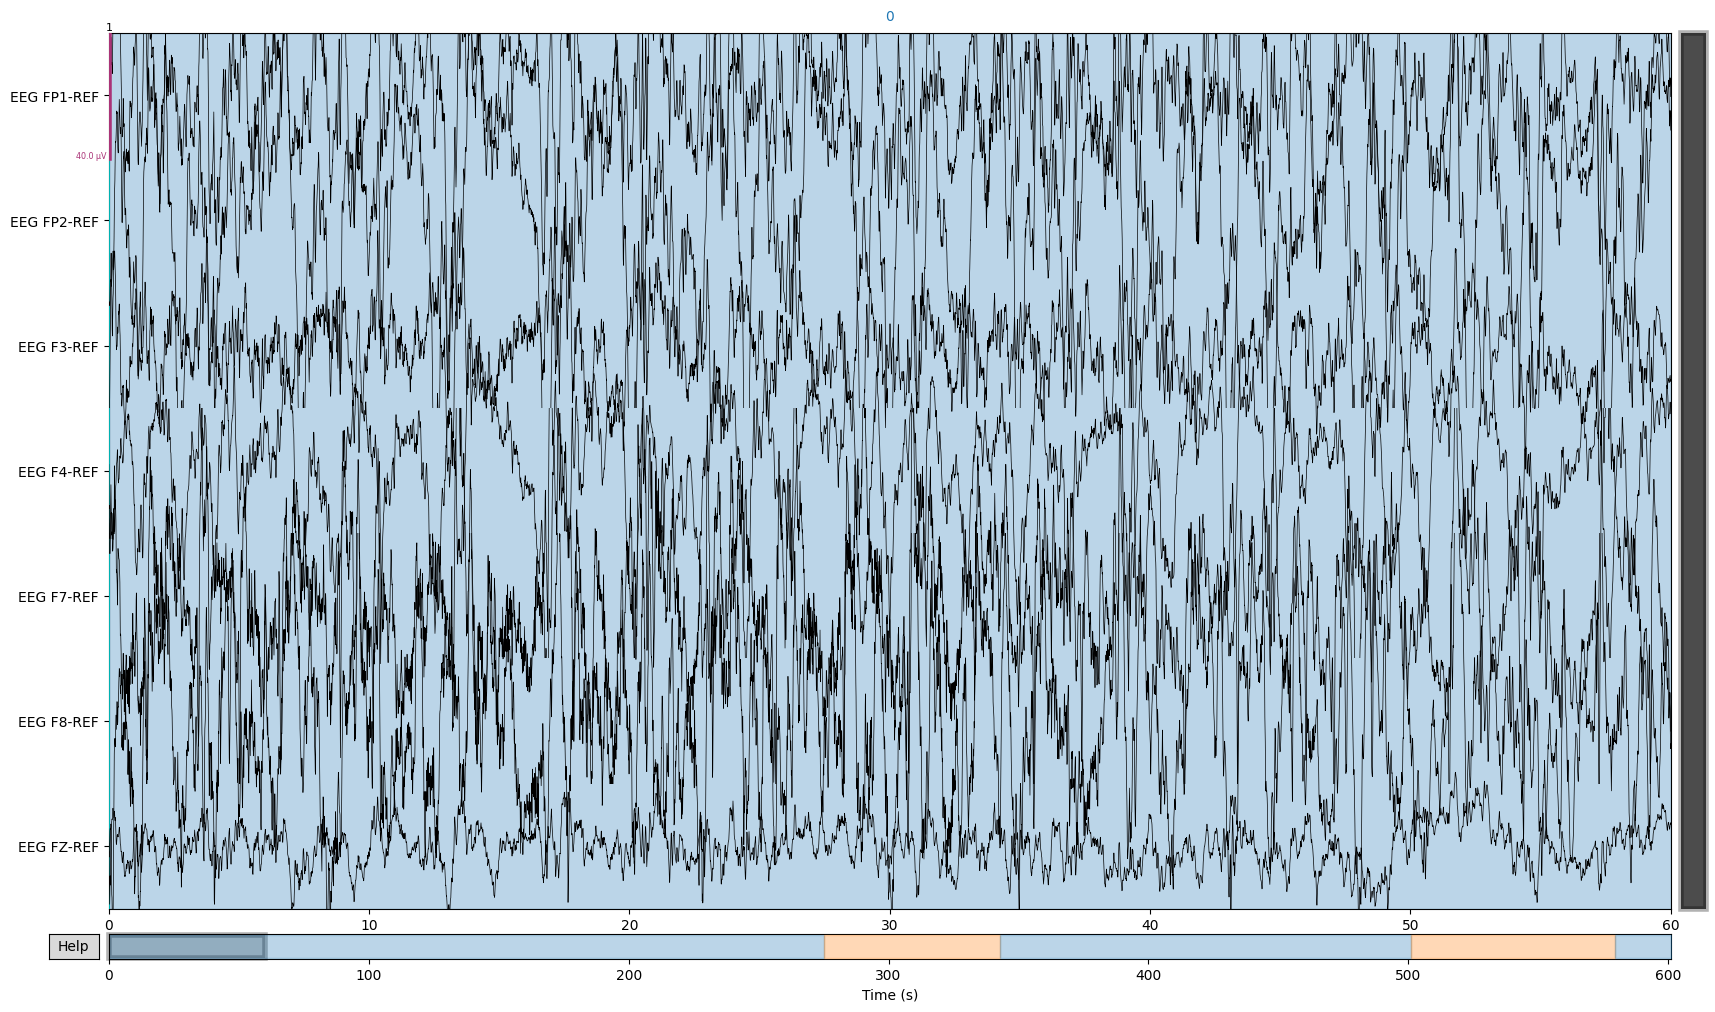

In [113]:
set_annotations = mne.Annotations(
    annotation_times[0], annotation_times[1], annotation_times[2]
)
raw.set_annotations(set_annotations)
events, event_id = mne.events_from_annotations(raw)

raw.plot(events=events, start=0, duration=60, color={"0": "blue", "1": "red"})

## Split into Epochs/Windows


In [114]:
epoch_duration = 2
epoch_overlap = 1
epochs = mne.make_fixed_length_epochs(
    raw, duration=epoch_duration, overlap=epoch_overlap
)

epochs_vector = epochs.get_data()

Not setting metadata
600 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 600 events and 500 original time points ...
0 bad epochs dropped


Apply labels based on raw annotations


In [115]:
labels_list = [None] * len(epochs.events)
print(raw.annotations.description)
for i, v in enumerate(epochs.events):
    epoch_time_start = v[0] / 250
    epoch_time_end = epoch_time_start + epoch_duration
    epoch_range = list(range(math.floor(epoch_time_start), math.floor(epoch_time_end)))

    onset_list = []

    for j, k in enumerate(raw.annotations.onset):
        label_time_start = k
        label_time_end = k + (raw.annotations.duration[j])
        label_range = list(
            range(math.floor(label_time_start), math.floor(label_time_end))
        )

        count_in = 0
        count_out = 0

        for l in epoch_range:
            if l in label_range:
                count_in += 1
            else:
                count_out += 1

        onset_list.append(count_in / (count_in + count_out))

    for m, b in enumerate(onset_list):
        if b > 0.74 and (m % 2 != 0):
            max_inclusion_idx = m
            break
        if b == max(onset_list):
            max_inclusion_idx = m

    # print(onset_list)

    labels_list[i] = raw.annotations.description[max_inclusion_idx]

['0' '1' '0' '1' '0']


## Save Data

Save data to npy binary files.


In [116]:
epochs_vector = epochs.get_data()

which_folder = "two_second_windows"

epochs_vector_filepath = (
    f"processed_data/{SEIZURE_TYPE}/{which_folder}/{seizure_idx+1}/absence_data.npy"
)
epochs_labels_filepath = f"processed_data/{SEIZURE_TYPE}/{which_folder}/{seizure_idx+1}/absence_data_labels.npy"

np.save(epochs_vector_filepath, epochs_vector)
np.save(epochs_labels_filepath, labels_list)

Using data from preloaded Raw for 600 events and 500 original time points ...


In [117]:
# with open(f"processed_data/{SEIZURE_TYPE}/{which_folder}/epochs_files.csv", "w", newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(["data", "labels"])

In [118]:
with open(
    f"processed_data/{SEIZURE_TYPE}/{which_folder}/epochs_files.csv", "a", newline=""
) as f:
    writer = csv.writer(f)
    writer.writerow([epochs_vector_filepath, epochs_labels_filepath])